# Task 5 - Tests

In [4]:
from helpers.cellular_automaton import fill_from_scenario_file, CellularAutomaton
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

## TEST1: RiMEA scenario 1 (straight line, ignore premovement time)

It is to be proven that a person in a 2 m wide and 40 m long corridor with a defined walking speed will cover the distance in the corresponding time period.
If 40 cm (body dimension), 1 second (premovement time) and 5% (walking speed) are set as imprecise values, then the following requirement results with a typical pedestrian speed of 1.33 m/sec: the speed should be set at a value between 4.5 and 5.1 km/h. The travel time should lie in the range of 26 to 34 seconds when 1.33 m/sec is set as the speed.

### Setup the Simulation

In [2]:
cellularAutomaton_task5_rimea1 = fill_from_scenario_file('scenario_files/tasks/scenario_task_5_rimea_1.csv')
cellularAutomaton_task5_rimea1.visualize_state_grid()

[P                                                                                                                    T]
[                                                                                                                      ]


### Run the Simulation and visualize afterwards

In [3]:
cellularAutomaton_task5_rimea1.simulate_until_no_change()
cellularAutomaton_task5_rimea1.visualize_simulation()

Iteration 0:
[P                                                                                                                    T]
[                                                                                                                      ]

Iteration 1:
[   P                                                                                                                 T]
[                                                                                                                      ]

Iteration 2:
[         P                                                                                                           T]
[                                                                                                                      ]

Iteration 3:
[            P                                                                                                        T]
[                                                                                                 

### Check the speed

In [4]:
finished_ped = cellularAutomaton_task5_rimea1.finished_pedestrians[0]
finished_ped

{'speed_desired': 1.33,
 'start_pos': (0, 0),
 'curr_pos': (0, 39),
 'travelled': 39.0,
 'skips': 0,
 'id': 0,
 'finish_iteration': 29}

In [5]:
print(f'Travel time: {finished_ped["finish_iteration"]} s')
print(f'Distance travelled: {finished_ped["travelled"]} m')
print(f'Speed Desired: {finished_ped["speed_desired"]} m/s')
print(f'Speed Achieved: {finished_ped["travelled"] / finished_ped["finish_iteration"]:.2f} m/s')

Travel time: 29 s
Distance travelled: 39.0 m
Speed Desired: 1.33 m/s
Speed Achieved: 1.34 m/s


## TEST2: RiMEA scenario 4 (fundamental diagram, be careful with periodic boundary conditions)

The figure shown below (Figure 4) is to be modelled (corridor 1000 m long, 10 m wide). There are three measuring points (2 x 2 m), the dotted of which is the main measuring point, with the other two grey measuring points functioning as control measuring points.

The corridor is to be filled with different densities of persons with an equal as possible free walking speed (for example 1.2 – 1.4m/s): 0.5 P/m², 1 P/m², 2 P/m², 3 P/m², 4 P/m², 5 P/m² and 6 P/m².

At the measuring points, the average speed of persons over a period of 60 seconds is to be determined for the specified density. The first 10 seconds can be ignored as a “transient response”. From the results (speed at the specified density), the corresponding fundamental diagrams can be created, with the calculation flow = speed * density taken as a basis for the flow of persons.

In order to ensure that the fundamental diagram is also reproduced by the program in case of a “line movement”, the corridor should be reduced in width to such a degree that the persons can only move one behind the other and overtaking is not possible.

![corridor](img/rimea_4_corridor.png)

### Assumptions / Differences from the official Description:
- 1 cell = 0.5m
- 1 person per cell
- 1 iteration = 0.5s
- width of corridor = 20m
- height of corridor = 5m
- considered densities: [0.5, 1.0, 2.0, 3.0, 4.0] p/m²
- measuring place only one cell as dimensions (not the 2m x 2m)
- measuring the last 10 iterations

### Generate the Data

In [24]:
M_PER_CELL = 0.5  # meter per cell unit
SPEED = 1  # m/s
HEIGHT_M = 5  # height of the grid in meter
WIDTH_M = 20  # width of the grid in meter
S_PER_IT = 0.5  # seconds per iteration in the simulation
LOOKBACK = 10  # how many iterations to look back when measuring the speed
IGNORE_FIRST = 10  # number of iterations at the beginning to ignore

def get_pos_idx_without_replacement(height: int, width: int, num_samples: int):
    x = np.arange(width)
    y = np.arange(height)
    xv, yv = np.meshgrid(x, y)
    c = np.random.choice(width * height, num_samples, replace=False)
    return [(b, a) for a, b in zip(xv.flatten()[c], yv.flatten()[c])]

# define grid
height, width = int(HEIGHT_M / M_PER_CELL), int(WIDTH_M / M_PER_CELL)
m1 = (int(height / 2), int(width / 2)) # measuring point
cellularAutomaton_task5_rimea4 = CellularAutomaton((height, width + 1))

# set targets
for i in range(height):
    cellularAutomaton_task5_rimea4.add_target((i, width))

# save configuration
savedCellularAutomata = deepcopy(cellularAutomaton_task5_rimea4)

densities = [0.5, 1, 2, 3, 4]  # in p / m²
avg_vels = {}  # dict to save final results
for d in densities:
    currentCellularAutomata = deepcopy(savedCellularAutomata)

    # place all pedestrians to achieve desired density
    d_converted = d * M_PER_CELL ** 2  # convert from p / m² to p / cell
    num_ped = int(d_converted * height * width)   # number of pedestrians we need to place on the grid
    # sample and place
    ped_idx = get_pos_idx_without_replacement(height, width, num_ped)
    for ped_id in ped_idx:
        currentCellularAutomata.add_pedestrian(ped_id, speed_desired=SPEED * S_PER_IT / M_PER_CELL)
    
    # run the simulation
    currentCellularAutomata.simulate_until_no_change()

    # inspect afterwards, ignore first 10 iterations
    already_measured = []
    vels = []
    for iteration in range(IGNORE_FIRST, currentCellularAutomata.curr_iter):
        pedestrians = currentCellularAutomata.pedestrians_history[iteration]
        for ped in pedestrians:
            if ped['curr_pos'] == m1:
                if ped['id'] not in already_measured:
                    # check speed during last LOOKBACK iterations
                    pedestrians_before = currentCellularAutomata.pedestrians_history[iteration - LOOKBACK]

                    for ped_before in pedestrians_before:
                        if ped_before['id'] == ped['id']:
                            distance_before = ped_before['travelled']
                            distance_now = ped['travelled']
                            vels.append((distance_now - distance_before) * M_PER_CELL / (LOOKBACK * S_PER_IT))
                break  # only one person can be on the measurement point

    avg_vels[d] = np.average(vels)

avg_vels

{0.5: 1.0,
 1: 1.0,
 2: 0.9853553390593275,
 3: 0.8883655599729272,
 4: 0.8366138336304647}

### Extract Data for plot

In [44]:
densities = avg_vels.keys()
velocities = avg_vels.values()
flows = [density * velocity for density, velocity in zip(densities, velocities)]

### Create Fundamental Diagram

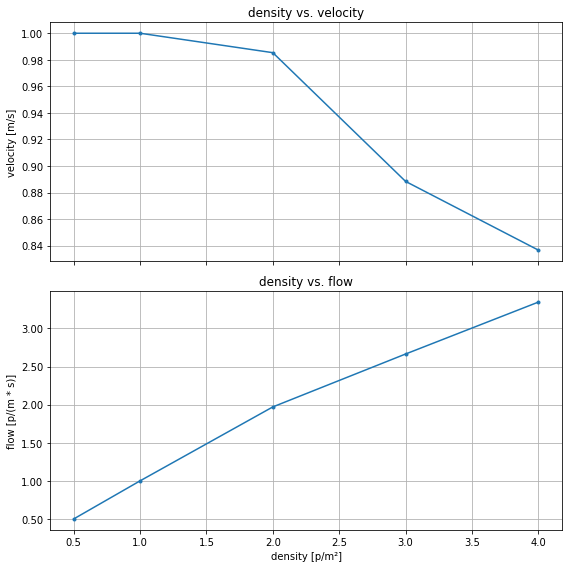

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

ax1.plot(densities, velocities, marker='.')
ax1.grid()
ax1.set_ylabel('velocity [m/s]')
ax1.set_title('density vs. velocity')

ax2.plot(densities, flows, marker='.')
ax2.grid()
ax2.set_ylabel('flow [p/(m * s)]')
ax2.set_xlabel('density [p/m²]')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_title('density vs. flow')

plt.tight_layout()
fig.savefig('exports/fundamental_diagram.pdf')

## TEST3: RiMEA scenario 6 (movement around a corner)
Twenty persons moving towards a corner which turns to the left (Figure 5) will successfully go around it without passing through walls.

![Crossway](img/rimea_6_crossway.png)

### Assumptions
- 1 cell = 0.5 m
- 1 person = 1 cell

### Setup the simulation

In [7]:
cellularAutomaton_task5_rimea6 = fill_from_scenario_file('scenario_files/tasks/scenario_task_5_rimea_6.csv')
cellularAutomaton_task5_rimea6.visualize_state_grid()

[                                                         O  T  T  T  T]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                  

### Run the simulation and visualize afterwards

In [8]:
cellularAutomaton_task5_rimea6.simulate_until_no_change()
cellularAutomaton_task5_rimea6.visualize_simulation()

Iteration 0:
[                                                         O  T  T  T  T]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                                         O            ]
[                                     

## TEST4: RiMEA scenario 7 (demographic parameters, visual comparison of figure and results is sufficient. Simple and correct statistical test gives 5 bonus points)
Select a group consisting of adult persons in accordance with Figure 2 and distribute the walking speeds over a population of 50 persons. Show that the distribution of walking speeds in the simulation is consistent with the distribution in the table.

![Walking speed over age](img/rimea_7_speed_age.png)

### Sample the data

In [5]:
HEIGHT = 20
WIDTH = 50

walking_speed_per_age = {
    10: 1.2,
    20: 1.6,
    30: 1.53,
    40: 1.5,
    50: 1.4,
    60: 1.25,
    70: 1.1,
    80: 0.7,
}

ages = list(walking_speed_per_age.keys())
velocities = list(walking_speed_per_age.values())
test_ages = np.linspace(10, 80, HEIGHT)
test_velocities = np.interp(test_ages, ages, velocities)

### Run the Simulation

In [6]:
# define grid
cellularAutomaton_task5_rimea7 = CellularAutomaton((HEIGHT, WIDTH))

# place targets at the very end
for i in range(HEIGHT):
    cellularAutomaton_task5_rimea7.add_target((i, WIDTH-1))

for i, (test_age, test_velocity) in enumerate(zip(test_ages, test_velocities)):
    cellularAutomaton_task5_rimea7.add_pedestrian((i, 0), speed_desired=test_velocity, age=test_age)

# simulate
cellularAutomaton_task5_rimea7.simulate_until_no_change()

### Visualize the Results

In [7]:
cellularAutomaton_task5_rimea7.visualize_simulation()

Iteration 0:
[P                                                                                                                                                  T]
[P                                                                                                                                                  T]
[P                                                                                                                                                  T]
[P                                                                                                                                                  T]
[P                                                                                                                                                  T]
[P                                                                                                                                                  T]
[P                                                                               

### Plot the Data

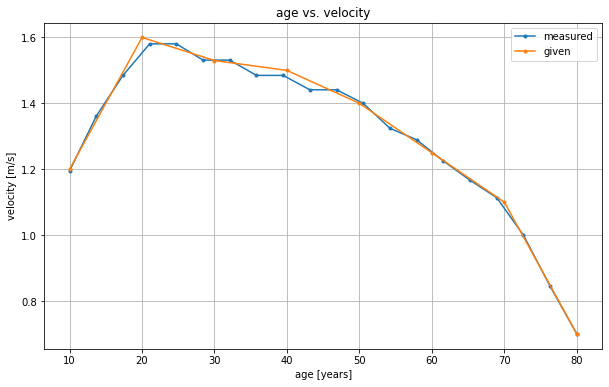

In [99]:
# analyze afterwards
measured_velocities = {}
for ped in cellularAutomaton_task5_rimea7.finished_pedestrians:
    measured_velocities[ped['age']] = ped['travelled'] / ped['finish_iteration']

# plot
measured_velocities_sorted_by_age = dict(sorted(measured_velocities.items(), key=lambda item: item[0]))
plt.figure(figsize = (10,6))
plt.plot(measured_velocities_sorted_by_age.keys(), measured_velocities_sorted_by_age.values(), marker='.', label='measured')
plt.plot(ages, velocities, marker='.', label='given')
plt.xlabel('age [years]')
plt.ylabel('velocity [m/s]')
plt.title('age vs. velocity')
plt.legend()
plt.grid()
fig.savefig('exports/age_vs_velocity.pdf')